# 1. 파이토치로 구현하는 ANN

## 1-1. 텐서와 Autograd
차원(Rank)과 Shape

- 텐서의 차원 변환
    - unsqueeze
    - squeeze
    - view

In [3]:
import torch

x = torch.tensor([[1,2], [3,4], [5,6]])
print(x)
print(x.size())
print(x.shape)
print(x.ndimension()) # 텐서 랭크(차원)

x = torch.unsqueeze(x, 0) # 0번째 차원에 1차원 추가
print(x)
print(x.size())
print(x.shape)
print(x.ndimension())

x = torch.squeeze(x) # 1 차원 제거
print(x)
print(x.size())
print(x.shape)
print(x.ndimension())

x = x.view(6) # 텐서의 모양을 바꿈
print(x)
print(x.size())
print(x.shape)
print(x.ndimension())

x = x.view(-1,3)
print(x)
print(x.size())
print(x.shape)
print(x.ndimension())


tensor([[1, 2],
        [3, 4],
        [5, 6]])
torch.Size([3, 2])
torch.Size([3, 2])
2
tensor([[[1, 2],
         [3, 4],
         [5, 6]]])
torch.Size([1, 3, 2])
torch.Size([1, 3, 2])
3
tensor([[1, 2],
        [3, 4],
        [5, 6]])
torch.Size([3, 2])
torch.Size([3, 2])
2
tensor([1, 2, 3, 4, 5, 6])
torch.Size([6])
torch.Size([6])
1
tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])
torch.Size([2, 3])
2


- 행렬 연산 - 곱 : torch.mm(a,b)

In [4]:
w=torch.randn(5,3, dtype=torch.float)
x=torch.tensor([[1.0,2.0], [3.0,4.0], [5.0,6.0]])
print(w.size())
print(x.size())
print(torch.mm(w,x)) # 행렬곱

torch.Size([5, 3])
torch.Size([3, 2])
tensor([[  8.5884,  11.0972],
        [ -2.7259,  -2.9932],
        [ -9.0766, -12.4327],
        [  1.2372,  -0.0435],
        [ -8.6440, -11.3647]])


- 기울기 계산 : Autograd

In [5]:
w = torch.tensor(1.0, requires_grad=True)
a = w*3
l = a**2
l.backward()
print('l을 w로 미분한 값은 {}'.format(w.grad))

l을 w로 미분한 값은 18.0


## 1-2. 경사하강법 구현

Loss at 0 = 12.04658031463623
Loss at 1000 = 1.1086004972457886
Loss at 2000 = 0.5271691679954529
Loss at 3000 = 0.3670985698699951
Loss at 4000 = 0.29153716564178467
Loss at 5000 = 0.24507474899291992
Loss at 6000 = 0.21170102059841156
Loss at 7000 = 0.1850699484348297
Loss at 8000 = 0.16230298578739166
Loss at 9000 = 0.14196588099002838
Loss at 10000 = 0.12327602505683899
Loss at 11000 = 0.10576756298542023
Loss at 12000 = 0.08914084732532501
Loss at 13000 = 0.07319123297929764
Loss at 14000 = 0.057773489505052567
Loss at 15000 = 0.042782966047525406
Loss at 16000 = 0.028145719319581985
Loss at 17000 = 0.021156998351216316
Loss at 18000 = 0.021166004240512848
Loss at 19000 = 0.021167544648051262


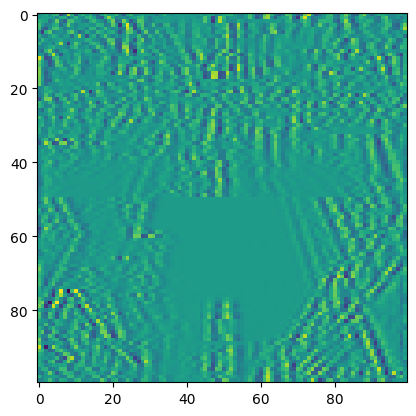

In [4]:
import pickle
import matplotlib.pyplot as plt
import torch
from torch import rand

broken_image = torch.FloatTensor(pickle.load(open('../03-파이토치로_구현하는_ANN/broken_image_t.p', 'rb'), encoding='latin1'))
plt.imshow(broken_image.view(100,100))

def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

def distance_loss(hypothesis, broken_image):    
    return torch.dist(hypothesis, broken_image)

random_tensor = torch.randn(10000, dtype = torch.float)

lr = 0.8
for i in range(0,20000):
    random_tensor.requires_grad_(True)
    hypothesis = weird_function(random_tensor)
    loss = distance_loss(hypothesis, broken_image)
    loss.backward()
    with torch.no_grad():
        random_tensor = random_tensor - lr*random_tensor.grad
    if i % 1000 == 0:
        print('Loss at {} = {}'.format(i, loss.item()))

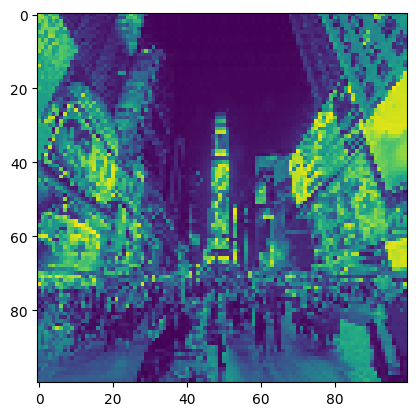

In [5]:
plt.imshow(random_tensor.view(100,100).data)

## 1-3. 인공신경망 구현

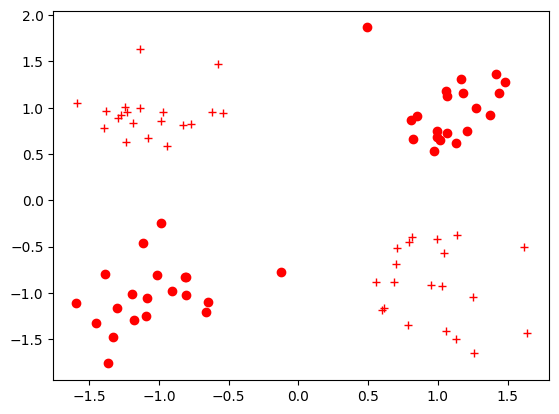

In [12]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [13]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

class NeuralNet(torch.nn.Module): ## nn.Module을 상속받으면 파이토치 프레임워크에서 제공하는 기능을 사용할 수 있음
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1)
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output
        
model = NeuralNet(2, 5)
learning_rate = 0.03
criterion = torch.nn.BCELoss()
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) ## 모델 내부 정보를 넘김

# 학습전 모델 평가
model.eval() ## 평가모드 on
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

torch.Size([80, 2])
Before Training, test loss is 0.6887685656547546


In [15]:
# 신경망 학습
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.06498576700687408
Train loss at 100 is 0.060904134064912796
Train loss at 200 is 0.05727822706103325
Train loss at 300 is 0.05403488874435425
Train loss at 400 is 0.05112046003341675
Train loss at 500 is 0.048493821173906326
Train loss at 600 is 0.04611001908779144
Train loss at 700 is 0.043937746435403824
Train loss at 800 is 0.04195081442594528
Train loss at 900 is 0.04012719541788101
Train loss at 1000 is 0.038447894155979156
Train loss at 1100 is 0.036896802484989166
Train loss at 1200 is 0.03545994684100151
Train loss at 1300 is 0.03412557765841484
Train loss at 1400 is 0.03288327902555466
Train loss at 1500 is 0.03172391280531883
Train loss at 1600 is 0.030639436095952988
Train loss at 1700 is 0.029622923582792282
Train loss at 1800 is 0.028668254613876343
Train loss at 1900 is 0.02777012065052986


In [16]:
# 학습 후 평가
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

# 학습된 가중치 저장
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

After Training, test loss is 0.018792448565363884
state_dict format of the model: OrderedDict({'linear_1.weight': tensor([[-1.6053,  1.8430],
        [ 0.1287,  0.6128],
        [-2.3877, -1.4010],
        [ 1.1835,  2.3827],
        [ 0.3937, -0.0106]]), 'linear_1.bias': tensor([-0.2116,  0.1051, -0.0133, -0.4200, -0.6601]), 'linear_2.weight': tensor([[ 2.3576, -0.6118, -2.7415, -2.6329, -0.1751]]), 'linear_2.bias': tensor([2.7896])})


In [17]:
# 전이 학습
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.995226263999939
